<center>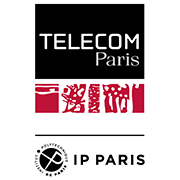</center>

<h1><center><strong><font color='crimson'>
  IA 717: Poetry Generation Project
</font></strong></center></h1>

<center>
  <h3> Project Supervisor <br/> Cyril Chhun</h3>
  <email>cyril.chhun@telecom-paris.fr</email>
  <br/>
  Year 2021-2022
</center>

<h3><center><font color='cornflowerblue'><strong>
    Student Version  
</strong></font></center></h3>

<student><center>

  Ramzi Khalifa
  <br/>Louis-Gabriel Pouillot
  <br/>Yann Rodriguez
</student></center>

---
# <font color="crimson">__SETUP__</font>

## __Packages__

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pprint
import string
import random
import spacy
import torch
import nltk
import time
import math
import os
import sys

# for display
import json
import pandas as pd
import plotly.express as px

# timezone for timestamp
import datetime
import pytz 

import re

# garbage collector of collab
import gc

pp = pprint.PrettyPrinter()


## __Mount drive google & setup cuda/cpu device__

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
  # drive.mount("/content/drive", force_remount=True)


# Use CUDA if on a GPU :
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = str(device)
print("Using device : " , device)

Mounted at /content/drive
Using device :  cuda


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
def clean_memory():
  gc.collect()
  torch.cuda.empty_cache()

clean_memory()

## __Paths__

TODO :
- create directories *_PATH 

In [ ]:
if IN_COLAB:
    ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/IA717_NLP_Poem_project/'

else:
    ROOT_PATH = './'

# DRAMACODE_PATH  = os.path.join(ROOT_PATH, 'dramacode.github.io')
# NAKED_PATH = os.path.join(DRAMACODE_PATH , 'naked')
# NAKED_CLEAN_PATH = os.path.join(DRAMACODE_PATH, 'naked_clean')
# NAKED_POSTAGGED_PATH = os.path.join(DRAMACODE_PATH, 'naked_pos_tagged')

CORPUS_PATH = os.path.join(ROOT_PATH , 'dramacode_corpus')
CHECKPOINT_PATH = os.path.join(ROOT_PATH, 'dramacode_checkpoints')

# # EXTRAS 
# MARKDOWN_PATH = os.path.join(DRAMACODE_PATH, 'markdown')
# OUTPUTS_PATH = os.path.join(ROOT_PATH , 'outputs')

# EXTENSIONS OF FILES
EXTENSION_REPORT = '_report.txt'
EXTENSION_PARAMS = '_params.txt'
EXTENSION_OUTPUT = '_output.txt'
EXTENSION_POEMS = '_poems.txt'
EXTENSION_MODEL  = '.pt'


## __Params__

### Setup



In [ ]:
# 0. using a normalized files
NORMALIZE_CORPUS=False
MAX_NORMALIZE=15
 
# 1. CORPUS FILE NAME PREFIX AND MODEL PREFIX (can be left empty)
CORPUS_PREFIX=""
MODEL_PREFIX="H_2_"
		
# 2. choose the mode (exclusive, first true gets it all)
MODE = "TRAIN"
# MODE = "TRAIN MORE"

# 3. if in TRAIN_MORE set the model name 
EXISTING_MODEL_NAME = 'H_1_model_cuda_20220204_094757'  # Do not add '.pt' at the end
# END SETUP # 

Set training params also [here](#scrollTo=9t-V77T9cZP3)

### Notice
No need to change anything below. Do it on previous setup cell

In [ ]:
DEBUG = False

In [ ]:
tz = pytz.timezone('Europe/Paris')
currentDT = datetime.datetime.now(tz)
TIMESTAMP = currentDT.strftime("%Y%m%d_%H%M%S")

if MODE == "TRAIN":
  LOAD_EXISTING_MODEL = False
  TRAIN = True

elif MODE == "TRAIN MORE":
  LOAD_EXISTING_MODEL = True
  TRAIN = True

FILE_CORPUS  =f"{CORPUS_PREFIX}corpus.txt"
FILE_TRAIN   =f"{CORPUS_PREFIX}train.txt"
FILE_TEST    =f"{CORPUS_PREFIX}test.txt"
FILE_VALID   =f"{CORPUS_PREFIX}valid.txt"

NORMED='' # prefix used for model name and corpus files
if NORMALIZE_CORPUS:
  NORMED = 'normalized_'

if LOAD_EXISTING_MODEL:
  MODEL_NAME = EXISTING_MODEL_NAME
else:
  # MODEL_NAME model_[cuda|cpu]_[TIMESTAMP] or normalized_model_[cuda|cpu]_[TIMESTAMP]
  MODEL_NAME = f'{MODEL_PREFIX}{NORMED}model_{DEVICE}_{TIMESTAMP}'

SAVE_PATH = os.path.join(CHECKPOINT_PATH, f'{MODEL_NAME}{EXTENSION_MODEL}')
REPORT_PATH = os.path.join(CHECKPOINT_PATH, f'{MODEL_NAME}{EXTENSION_REPORT}')

In [ ]:
print(f"Model name used is ==> {MODEL_NAME}")
print(f"Corpus used is     ==> {FILE_CORPUS}")

Model name used is ==> H_1_model_cuda_20220204_094757
Corpus used is     ==> corpus.txt


In [ ]:
def get_length_lines(filepath, max_norm=None):
  """
  Returns the lenght of longest words list in lines 
  and the list of lines with max_norm tokens
  """
  max_len = 0
  valid_lines=[]
  with open(filepath,'r') as f:
    all_lines = f.readlines()
    # print(len(all_lines))
    for line in all_lines:
        num_tokens  = len(line.split())

        if num_tokens > max_len:
          max_len = num_tokens

        if max_norm:
          if num_tokens > max_norm:
            # exclure la line
            continue

        valid_lines.append(line)

    if max_norm:
        max_len = min(max_norm, max_len)

  if DEBUG: print(f"Max num of tokens in lines : {max_len}")
  return (max_len, valid_lines)

## Implementing the model

### Building the dictionary

First, we need to build a dictionary so that we can pass words as unique identifiers, usually integers, to the model.

In [ ]:
# Modified 

class Dictionary(object):
    def __init__(self):
        self.word2idx = {}  # if word2idx["hello"] == 42 ...
        self.idx2word = []  # ... then idx2word[42] == "hello" 

    def add_word(self, word):
        """ 
          This function should check if the word is in word2idx; if it
          is not, it should add it with the first available index
        """
        pos = self.__len__()
        # check si mot présent
        p = self.word2idx.get(word, pos)
        if p == pos:
          self.word2idx[word]=p
          self.idx2word.append(word)
        return p

    def __len__(self):
        return len(self.idx2word)

### Building the corpus

In [ ]:
# Modified

class Corpus(object):
    def __init__(self, path):
        # We create an object Dictionary associated to Corpus
        self.dictionary = Dictionary()
        self.sos_token = '<sos>' # start of sentence (line) token
        self.eos_token = '<eos>' # end of sentence (line) token
        # self.sos_id = self.dictionary.add_word('<sos>')
        self.eos_id = self.dictionary.add_word('<eos>')

        # We go through all files, adding all words to the dictionary
        print(f"Loading {FILE_TRAIN}, {FILE_VALID} and {FILE_TEST}")
        self.train = self.tokenize( os.path.join(path, FILE_TRAIN) )
        self.valid = self.tokenize( os.path.join(path, FILE_VALID) )
        self.test = self.tokenize( os.path.join(path, FILE_TEST)   )

    def tokenize(self, path):
        """
            Tokenizes a text file, knowing the dictionary, in order to 
            tranform it into a list of indices.
            The str.split() function might be useful.
        """

        assert os.path.exists(path)

        ids = []
        c=0
        with open(path,'r') as f:
          for line in f:
            tokens = line.split()
            # print(len(tokens))
            if NORMALIZE_CORPUS and len(tokens) > MAX_NORMALIZE:
              # print(len(tokens))
              c+=1
              continue
            else:
              # dictionary.add_word returns the id of the word in Dictionnary idx2word list
              line_ids = [self.dictionary.add_word(token) for token in tokens]
              
              # Lines start with the sos token
              #ids.append(self.sos_id)
              # Then line_ids
              ids.extend(line_ids)
              # Lines end with the eos token
              ids.append(self.eos_id)
       
        if DEBUG : 
          print('\n')
          print(f'Suppression de {c} vers de taille > {MAX_NORMALIZE} ')
        # We want the `ids` vector to be an int64 torch tensor containing all 
        # tokens in the order of the file.
        return torch.tensor(ids,dtype=torch.int64)
    
    def to_words(self, tensor):
        return ' '.join([self.dictionary.idx2word[int(val)] for val in tensor])

### Loading the data

In [ ]:
# Modified

print(f"Loading corpus from {CORPUS_PATH.split('/')[-1]}...", end=" ")
corpus = Corpus(CORPUS_PATH)
print("Done")


Loading corpus from dramacode_corpus... Loading train.txt, valid.txt and test.txt
Done


In [ ]:
if DEBUG:
  # for control
  words_path = os.path.join(CHECKPOINT_PATH, f'words.txt')
  with open(words_path, 'w') as f:
    pat=""
    for i in range(len(corpus.dictionary.idx2word)):
      f.write(corpus.dictionary.idx2word[i]+'\n')
    

In [ ]:
# Added

def report():
  print(f"Corpus path    : {CORPUS_PATH}")
  print(f"Corpus extract : {corpus.train[:50]}")
  print(f"Dictionary length  : {len(corpus.dictionary)}")
  print(f"Dictionary extract : {corpus.dictionary.idx2word[:30]}")
  print(f"Dictionary length  : {len(corpus.dictionary)}")
  print("Corpus train len    :", len(corpus.train))
  print("Corpus test  len    :", len(corpus.test))
  print("Corpus valid len    :", len(corpus.valid))

report()

Corpus path    : /content/drive/MyDrive/Colab Notebooks/IA717_NLP_Poem_project/dramacode_corpus
Corpus extract : tensor([ 1,  2,  3,  4,  5,  2,  6,  7,  8,  0,  9, 10, 11, 12, 13, 14, 15,  0,
        16, 11, 17, 18, 19, 20, 21, 22, 23, 24, 18, 25, 26,  0, 27, 28, 29,  9,
        30, 16, 17, 31, 32, 33, 21,  0, 16, 34, 35, 21, 22, 16])
Dictionary length  : 88690
Dictionary extract : ['<eos>', '"', 'un', 'pigmée', 'innocent', 'vaincre', 'coupable', 'alcide', '.', 'que', 'ne', 'nous', 'rendez-vous', 'cette', 'infame', 'beauté', 'qui', 'fait', 'tant', 'de', 'peine', ',', 'et', 'vous', 'a', 'cousté', '?', "c'est", 'elle', 'plus']
Dictionary length  : 88690
Corpus train len    : 6324518
Corpus test  len    : 788767
Corpus valid len    : 791003


### Batching the data

#### `batchify`

Our `corpus.train`, `corpus.valid` and `corpus.test` tensors are flat tensors; they cannot efficiently be processed with a gpu.
We will therefore want to change their shape so that they are more square-like.

With the alphabet being our data, we currently have the sequence:
`[a b c d e f g h i j k l m n o p q r s t u v w x y z]`. We want to reorganize it as independant batches that will be processed independently by the model !

For instance, with the alphabet as the sequence and batch size 4, we'd get the 4 following sequences (represented as columns):
```
┌ a g m s ┐
│ b h n t │
│ c i o u │
│ d j p v │
│ e k q w │
└ f l r x ┘
```
with the last two elements being lost.

Again, these columns are treated as independent by the model, which means that the dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient processing.

❓ **Question**: what do you think of this batching process? For instance, is it adapted to our data? If yes, how so? If not, how could we improve it?

In [ ]:
# Modified

def batchify(data, bsz):
    """
        Three steps:
        1. Work out how cleanly we can divide the dataset into bsz parts.
        2. Trim off any extra elements that wouldn't cleanly fit (remainders).
        3. Evenly divide the data across the bsz batches.
        Note: You might need to use `.contiguous()` at the end because PyTorch can be somewhat strict about memory usage.
    """
    return data[:(data.shape[0]//bsz)*bsz].reshape(bsz,-1).T.to(device)

In [ ]:
def test_batchify():
    data = torch.tensor(np.arange(24))
    print(batchify(data, 4))

# test_batchify()

##### Expected result


```
tensor([[ 0,  6, 12, 18],
        [ 1,  7, 13, 19],
        [ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]])
```

#### `get_batch` function

Now we will build a function `get_batch` which subdivides the source data into chunks of the appropriate length. This function will be used later in the model training and evaluation.

If source is equal to the example output of the batchify function, with
a sequence length (seq_len) of 3, we'd get the following two variables:

```
┌ a g m s ┐ ┌ b h n t ┐
| b h n t | | c i o u │
└ c i o u ┘ └ d j p v ┘
```

The first variable contains the letters input to the network, while the second
contains the one we want the network to predict (b for a, h for g, v for u, etc..)

Note that despite the name of the function, the subdivison of data is not done along the batch dimension (i.e. dimension 1), since that was handled by the `batchify` function. The chunks are along dimension 0, corresponding to the `seq_len` dimension in the LSTM.

In [ ]:
# Modified

def get_batch(source, i, seq_len):
    """
        Should return (data, target) where data would be the first variable of 
        the example above, and target the second variable.


        - source is the source data;
        - i is the position of the current sequence;
        - seq_len is the sequence length;

        Three steps:
        1. Deal with the possibility that there's not enough data left for a full sequence
        2. Take the input data
        3. Shift by one for the target data
    """
    if source.shape[0] < i+seq_len+1:
        return source[i:i+source[i+1:].shape[0]], source[i+1:]
    else :
        return source[i:i+seq_len], source[i+1:i+seq_len+1]

In [ ]:
def test_get_batch():
    source = torch.tensor(np.arange(26))
    source = batchify(source, 4)
    pp.pprint(get_batch(source, 2, 3))

# test_get_batch()

##### Expected result

```
(tensor([[ 2,  8, 14, 20],
        [ 3,  9, 15, 21],
        [ 4, 10, 16, 22]]),
 tensor([[ 3,  9, 15, 21],
        [ 4, 10, 16, 22],
        [ 5, 11, 17, 23]]))
```

#### Batchifying the corpus

In [ ]:
# Modified

BATCH_SIZE = 128 # Default: 128  - you can choose other values
EVAL_BATCH_SIZE = 16  # Default: 16 - you can choose other values

train_data = batchify(corpus.train, BATCH_SIZE)
val_data = batchify(corpus.valid, EVAL_BATCH_SIZE)
test_data = batchify(corpus.test, EVAL_BATCH_SIZE)

In [ ]:
print(corpus.train.shape, train_data.shape)
print(corpus.valid.shape, val_data.shape)
print(corpus.test.shape, test_data.shape)

torch.Size([6324518]) torch.Size([49410, 128])
torch.Size([791003]) torch.Size([49437, 16])
torch.Size([788767]) torch.Size([49297, 16])


In [ ]:
pp.pprint(train_data[:,0:16].T)
pp.pprint(val_data[:,0:16].T)
pp.pprint(test_data[:,0:16].T)

tensor([[    1,     2,     3,  ...,  1468,  1709,    21],
        [    0,  2798,   283,  ...,     0,   421,    66],
        [ 1459,   174,    48,  ...,  1209,    21,     0],
        ...,
        [    8,     0,  4577,  ...,   328,  1180,    19],
        [28187,   150,  1134,  ..., 10235,     2,  5192],
        [ 2733,   425,     0,  ...,   267,   368,   251]], device='cuda:0')
tensor([[    9,  2935,    19,  ...,  4311,   351,    99],
        [ 4232,    21,     0,  ...,  4647,    23,   145],
        [16635,    21,     0,  ...,    21,     0,    23],
        ...,
        [ 2014, 14036,  4163,  ...,  1677,  5312,   515],
        [   45,   469,  6565,  ...,    44,   267, 15575],
        [    0,    16, 31159,  ...,    26,     0,   743]], device='cuda:0')
tensor([[   22,  1200,   419,  ..., 14342,    21,   127],
        [  128,   629,  2143,  ...,    21,     0,   228],
        [   66,    99,   298,  ...,     8,  1334,   251],
        ...,
        [    9,  1236,    17,  ...,  2047,  3711,     0

##### Example expected result (your own corpus lengths and batch sizes may be different)

```
torch.Size([6987667]) torch.Size([54591, 128])
torch.Size([874006]) torch.Size([54625, 16])
torch.Size([872488]) torch.Size([54530, 16])
```

---
# <font color="crimson">__BUILDING THE MODEL__</font>

Models are usually implemented as custom nn.Module subclasses.
- We need to redefine the __init__ method, which creates the object.
- We also need to redefine the forward method, which transform the input into outputs.
- We can also add any method that we need: here, in order to initiate weights in the model.

Relevant documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM).

In [ ]:
# Modified

class LSTMModel(nn.Module):
    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.2, initrange=0.1):
        """
            ntoken: length of the dictionary,
            ninp: dimension of the input,
            nhid: dimension of the hidden layers,
            nlayers: number of layers,
            dropout: regularization parameter
            initrange: range for weight initialization
        """
        super().__init__()
        self.ntoken = ntoken
        self.nhid = nhid
        self.nlayers = nlayers
        self.initrange = initrange

        ## Modified
        # Create a dropout object to use on layers for regularization
        self.drop = nn.Dropout(p=dropout)  # Done, check nn.Dropout

        # Create an encoder - which is an embedding layer
        self.encoder = nn.Embedding(ntoken, ninp)  # Done, check nn.Embedding

        # Create the LSTM layers - find out how to stack them !
        self.rnn =  nn.LSTM(ninp, nhid, nlayers, dropout=dropout)  # Done, check nn.LSTM

        # Create what we call the decoder: a linear transformation to map the hidden state into scores for all words in the vocabulary
        # (Note that the softmax application function will be applied out of the model)
        self.decoder = nn.Linear(nhid,ntoken)  # Done, check nn.Linear
        ##


        # Initialize non-recurrent weights 
        self.init_weights()

    ## Modified
    def init_weights(self):
        """
            Initialize the encoder and decoder weights with the uniform distribution,
            between -initrange and +initrange, and the decoder bias with zeros
        """
        nn.init.uniform_(self.encoder.weight,-self.initrange,+self.initrange)
        nn.init.uniform_(self.decoder.weight,-self.initrange,+self.initrange)
        nn.init.zeros_(self.decoder.bias)
    ##

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))


    ## Modified
    def forward(self, input, hidden1):
        
        # Process the input with the encoder, then dropout
        emb = self.encoder(input) # EMBEDING
        emb = self.drop(emb) 

        # Apply the LSTMs
        output, hidden2 = self.rnn(emb,hidden1)
        output = self.drop(output)
        
        # Decode into scores
        decoded = self.decoder(output)
        return decoded, hidden2
    ##



❓ **Question**: how does the method `LSTMModel.init_hidden` work?

initiaise de façon uniforme les paramètres

loi normale unifirme [0,1]


---
# <font color="crimson">__TRAINING__

### Initializing the parameters

In [ ]:
# Choose a seed for reproductibility
SEED = 567
torch.manual_seed(SEED)


# Modified
EMBEDDING_SIZE = 512   #Default: EMBEDDING_SIZE = 512
HIDDEN_SIZE = 1024       #Default: HIDDEN_SIZE = 1024
N_LAYERS = 3            #Default: N_LAYERS = 2
DROPOUT = 0.35         #Default: DROPOUT = 0.2
criterion = nn.CrossEntropyLoss()  # maps the output of a Linear layer to a probability distribution
                                   # see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

# Modified                                   
N_TOKENS = corpus.dictionary.__len__()
model =  LSTMModel(N_TOKENS, EMBEDDING_SIZE, HIDDEN_SIZE, N_LAYERS, dropout=DROPOUT).to(device)


# You do not need to thoroughly understand the contents of this cell.
# However, some resources are available in the comments if you are curious.
# The values are not necessarily optimal, by the way;
# you could try to tune them later if you have the time.

# Learning Rate 
LR = 10 # DEFAULT https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10

OPTIMIZER = 'sgd'  # https://ruder.io/optimizing-gradient-descent/

WDECAY = 0.0001 # DEFAULT https://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html

CLIP = 0.45  # Default: CLIP = 0.25 (https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)


if OPTIMIZER == 'sgd':
    optim = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WDECAY)
elif OPTIMIZER == 'adam':
    optim = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WDECAY)
else:
    optim = None

if OPTIMIZER in ['sgd', 'adam']:
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1, gamma=0.7)
else:
    scheduler = None

# Other global parameters
EPOCHS = 5  # number of rounds of training, you can choose other values
SEQ_LEN = 30  # length of the sequences, you can choose other values
if NORMALIZE_CORPUS:
  SEQ_LEN = get_length_lines(os.path.join(CORPUS_PATH, FILE_CORPUS), max_norm=MAX_NORMALIZE)[0]  # TESTING
LOG_INTERVAL = 100  # for logging purposes, you can choose other values

In [ ]:
SEQ_LEN

30

### Reporting functions

In [ ]:
# Added
def report_save_hyperparams(to_file=None, display=True):
  PARAMS = ""
  
  PARAMS =  f"N_TOKENS = {N_TOKENS}\n"
  PARAMS += f"BATCH_SIZE = {BATCH_SIZE}\n"
  PARAMS += f"EVAL_BATCH_SIZE = {EVAL_BATCH_SIZE}\n"
  PARAMS += f"\n"
  PARAMS += f"EMBEDDING_SIZE = {EMBEDDING_SIZE}\n"
  PARAMS += f"HIDDEN_SIZE = {HIDDEN_SIZE}\n"
  PARAMS += f"N_LAYERS = {N_LAYERS}\n"
  PARAMS += f"\n"
  PARAMS += f"DROPOUT = {DROPOUT}\n"
  PARAMS += f"LR = {LR}\n"
  PARAMS += f"OPTIMIZER = \"{OPTIMIZER}\"\n"
  PARAMS += f"WDECAY = {WDECAY}\n"
  PARAMS += f"CLIP = {CLIP} \n"
  PARAMS += f"\n"
  PARAMS += f"EPOCHS = {EPOCHS}\n"
  PARAMS += f"SEQ_LEN = {SEQ_LEN} \n"
  PARAMS += f"LOG_INTERVAL = {LOG_INTERVAL}\n"
  PARAMS += f"SEED = {SEED}\n\n"
  
  CORPUS_INFO  = f"# Corpus path : {corpus.train[:300]}\n"
  CORPUS_INFO  = f"# Corpus extract : {CORPUS_PATH}\n"
  CORPUS_INFO += f"# Dictionary length : {len(corpus.dictionary)}\n"
  CORPUS_INFO += f"# Dictionary extract : {corpus.dictionary.idx2word[:30]}\n"
  CORPUS_INFO += f"# Dictionary length : {len(corpus.dictionary)}\n"
  CORPUS_INFO += f"# Corpus train {len(corpus.train)}\n"
  CORPUS_INFO += f"# Corpus test {len(corpus.test)}\n"
  CORPUS_INFO += f"# Corpus valid {len(corpus.valid)}\n"


  if display:
    print(f'Hyper params:\n')
    print(PARAMS)
    print(CORPUS_INFO)

  if to_file != None:
    # do not remove EXTENSION_PARAMS
    params_path = os.path.join(CHECKPOINT_PATH, f'{to_file}{EXTENSION_PARAMS}')
    with open(params_path, 'w') as f:
      f.write(PARAMS)
      f.write(CORPUS_INFO)
  else:
    print("\nWarning: Params not saved to file")


report_save_hyperparams(to_file="test")

Hyper params:

N_TOKENS = 88690
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 16

EMBEDDING_SIZE = 512
HIDDEN_SIZE = 1024
N_LAYERS = 3

DROPOUT = 0.35
LR = 10
OPTIMIZER = "sgd"
WDECAY = 0.0001
CLIP = 0.45 

EPOCHS = 5
SEQ_LEN = 30 
LOG_INTERVAL = 100
SEED = 567


# Corpus extract : /content/drive/MyDrive/Colab Notebooks/IA717_NLP_Poem_project/dramacode_corpus
# Dictionary length : 88690
# Dictionary extract : ['<eos>', '"', 'un', 'pigmée', 'innocent', 'vaincre', 'coupable', 'alcide', '.', 'que', 'ne', 'nous', 'rendez-vous', 'cette', 'infame', 'beauté', 'qui', 'fait', 'tant', 'de', 'peine', ',', 'et', 'vous', 'a', 'cousté', '?', "c'est", 'elle', 'plus']
# Dictionary length : 88690
# Corpus train 6324518
# Corpus test 788767
# Corpus valid 791003



In [ ]:
def load_json_file(path):
  if os.path.exists(path):
    with open(path, 'r') as f:
        data = f.read()
        data = json.loads(data)  
    return data
  else:
    return None

In [ ]:
# EXTRA
def report_loss(loss, epoch, lr, to_file=None):
  # do not remove extra file extension
  if to_file != None:
    path = os.path.join(CHECKPOINT_PATH, f'{to_file}{EXTENSION_REPORT}')
    
    # reading the data from the file if file exists or init
    content_dict = load_json_file(path)
    if content_dict == None:
      content_dict = {'loss': [], 'epoch': [], 'lr': []}

    # add loss to dict
    if content_dict.get('loss') == None: content_dict['loss'] = []
    content_dict['loss'].append(loss)

    if content_dict.get('epoch') == None: content_dict['epoch'] = []
    content_dict['epoch'].append(epoch)
 
    if content_dict.get('lr') == None: content_dict['lr'] = []
    content_dict['lr'].append(lr)

    # writing data to file or creating it if no file yet
    with open(path, 'w') as f:
      f.write(json.dumps(content_dict))
      if DEBUG: print(f'new value added {content_dict}')

  else:
    print('\nWarning: Loss not saved to file')


In [ ]:
# EXTRA
def report_output(output, to_file=None, to_extension="_default.txt", prefix=None):
  # do not remove extra file extension
  if to_file != None:
    fname = f'{to_file}{to_extension}'
    path = os.path.join(CHECKPOINT_PATH, fname)
    
    # writing data to file or creating it if no file yet
    with open(path, 'a') as f:
      if prefix:
        f.write("-"*len(prefix)+"\n"+prefix+"\n"+"-"*len(prefix)+"\n")
      f.write(output+'\n')
      if DEBUG: print(f'new value added to {fname}')

  else:
    print('\nWarning: Loss not saved to file')

### Core functions

In this section, everything is already implemented. However, there are a few questions below that you should try to answer so as to understand what is going on.

In [ ]:
def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

##### Train function

In [ ]:
print(train_data.size(0))

49410


In [ ]:
# Modified

def train():
    model.train()
    total_loss = 0.
    start_time = time.time()
    hidden = model.init_hidden(BATCH_SIZE)

    d = {'epoch': [], 'batches': [], 'total_batches': [], 'learning_rate': [], 'ms/batch': [], 'loss': [], 'ppl': []}
    df = pd.DataFrame(data=d)

    for batch, i in enumerate(range(0, train_data.size(0) - 1, SEQ_LEN)):
        data, targets = get_batch(train_data, i, SEQ_LEN)

        if optim is not None:
            optim.zero_grad()
        hidden = repackage_hidden(hidden)

        output, hidden = model(data, hidden)
        ## Modified
        if output is None:
          print('output none')
        if targets is None:
          print('targets none')  
        # loss = criterion(output.view(-1, N_TOKENS), targets.view(-1))
        loss = criterion(output.reshape(-1, N_TOKENS), targets.reshape(-1))
        ##


        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if CLIP is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)

        if optim is None:
            for p in model.parameters():
                p.data.add_(p.grad, alpha=-lr)
        else:
            optim.step()

        total_loss += loss.item()

        if batch % LOG_INTERVAL == 0 and batch > 0:
            cur_loss = total_loss / LOG_INTERVAL
            elapsed = time.time() - start_time
            report_loss(cur_loss, epoch, lr, to_file=MODEL_NAME)
            if optim is None:
                to_log = '| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // SEQ_LEN, lr, elapsed * 1000 / LOG_INTERVAL, cur_loss, math.exp(cur_loss))
                
                # report
                # LOG to file MODEL_NAME_output.txt
                report_output(to_log, to_file=MODEL_NAME, to_extension=EXTENSION_OUTPUT)
                print(to_log)

                # print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | '
                #     'loss {:5.2f} | ppl {:8.2f}'.format(
                #     epoch, batch, len(train_data) // SEQ_LEN, lr,
                #     elapsed * 1000 / LOG_INTERVAL, cur_loss, math.exp(cur_loss)))
            else:
                to_log = '| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // SEQ_LEN, scheduler.get_last_lr()[-1],elapsed * 1000 / LOG_INTERVAL, cur_loss, math.exp(cur_loss))
                                
                # report
                # LOG to file MODEL_NAME_output.txt
                report_output(to_log, to_file=MODEL_NAME, to_extension=EXTENSION_OUTPUT)
                print(to_log)

                # print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | '
                #         'loss {:5.2f} | ppl {:8.2f}'.format(
                #     epoch, batch, len(train_data) // SEQ_LEN, scheduler.get_last_lr()[-1],
                #     elapsed * 1000 / LOG_INTERVAL, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


In [ ]:
def evaluate(source):
    model.eval()
    total_loss = 0.
    hidden = model.init_hidden(EVAL_BATCH_SIZE)
    with torch.no_grad():
        for i in range(0, source.size(0) - 1, SEQ_LEN):
            data, targets = get_batch(source, i, SEQ_LEN)
            output, hidden = model(data, hidden)
            hidden = repackage_hidden(hidden)
            ## Modified
            # total_loss += len(data) * criterion(output.view(-1, N_TOKENS), targets.view(-1)).item()
            total_loss += len(data) * criterion(output.reshape(-1, N_TOKENS), targets.reshape(-1)).item()
            ##
    return total_loss / (len(source) - 1)

##### Sampling functions


❓ **Questions** whose answers will help you better understand what is happening:
1. What are `model.train()` and `model.eval()` for?



2. What is the `hidden` variable in the `train()` and `evaluate()` functions?



3. What is `loss.backward()` in `train()` for?



4. What is `optim.step()` for?



5. What is `repackage_hidden()` for?



6. How does the `generate()` function work?




### Training loop

#### Load model filename

In [ ]:
try:
    with open(SAVE_PATH, 'rb') as f:
        model = torch.load(f)
        # after load the rnn params are not a continuous chunk of memory
        # this makes them a continuous chunk, and will speed up forward pass
        model.rnn.flatten_parameters()
    print("Successfully loaded model from {}".format(SAVE_PATH.split('/')[-1]))
except:
    print("!! Could not load model from {}".format(SAVE_PATH.split('/')[-1]))
    pass
    
best_val_loss = None

!! Could not load model from H_2_model_cuda_20220213_195652.pt


#### Train


In [ ]:
clean_memory()

> <font color="crimson"> __Becarefull before executing this cell__: Did yout update the model filename ?</font>

In [ ]:
TRAIN, MODEL_NAME

(True, 'H_2_model_cuda_20220213_195652')

In [ ]:
if TRAIN:
  # Loop over epochs.
  # At any point you can hit Ctrl + C to break out of training early.
  print(f'Training model {MODEL_NAME}')
  try:
      lr = LR
      for epoch in range(1, EPOCHS+1):
          print(f"Processing EPOCH {epoch}/{EPOCHS}")
          epoch_start_time = time.time()
          train()
          val_loss = evaluate(val_data)
          if scheduler is not None:
              scheduler.step()
          print('-' * 89)
          print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
                  'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                            val_loss, math.exp(val_loss)))
          print('-' * 89)

          # saving lossa to file MODEL_NAME_report.txt
          report_loss(val_loss, epoch, lr, to_file=MODEL_NAME)

          # Save the model if the validation loss is the best we've seen so far.
          if not best_val_loss or val_loss < best_val_loss:
              with open(SAVE_PATH, 'wb') as f:
                  torch.save(model, f)
              print('Successfully saved model at {}'.format(SAVE_PATH))
              report_save_hyperparams(to_file=MODEL_NAME, display=False)
              best_val_loss = val_loss
          else:
              if scheduler is None:
                  lr /= 4.0

  except KeyboardInterrupt:
      print('-' * 89)
      print('Exiting from training early')
  finally:
      print(f'Check report file {MODEL_NAME}{EXTENSION_REPORT}')

Training model H_2_model_cuda_20220205_171043
Processing EPOCH 1/5
| epoch   1 |   100/ 1647 batches | lr 10.0000 | ms/batch 393.99 | loss  4.67 | ppl   107.08
| epoch   1 |   200/ 1647 batches | lr 10.0000 | ms/batch 389.62 | loss  4.61 | ppl   100.80
| epoch   1 |   300/ 1647 batches | lr 10.0000 | ms/batch 389.31 | loss  4.59 | ppl    98.89
| epoch   1 |   400/ 1647 batches | lr 10.0000 | ms/batch 389.42 | loss  4.57 | ppl    96.26
| epoch   1 |   500/ 1647 batches | lr 10.0000 | ms/batch 389.43 | loss  4.54 | ppl    93.46
| epoch   1 |   600/ 1647 batches | lr 10.0000 | ms/batch 389.47 | loss  4.55 | ppl    95.01
| epoch   1 |   700/ 1647 batches | lr 10.0000 | ms/batch 389.50 | loss  4.54 | ppl    93.64
| epoch   1 |   800/ 1647 batches | lr 10.0000 | ms/batch 389.58 | loss  4.55 | ppl    94.64
| epoch   1 |   900/ 1647 batches | lr 10.0000 | ms/batch 389.55 | loss  4.57 | ppl    96.50
| epoch   1 |  1000/ 1647 batches | lr 10.0000 | ms/batch 389.49 | loss  4.56 | ppl    95.96
| e

In [ ]:
names = ['epoch', 'batches', 'total_batches', 'learning_rate', 'ms/batch', 'loss', 'ppl']

filename_output = MODEL_NAME+ EXTENSION_OUTPUT
print(filename_output)
path_output     = os.path.join(CHECKPOINT_PATH, filename_output)

DF_EXISTS=False
if os.path.exists(path_output):

  df = pd.read_csv(path_output, sep='|', header=None)

  df.drop(0, inplace=True, axis=1)
  df[['batches', 'total_batches']] = df[2].str.split('/', 1, expand=True)
  df.drop(2, inplace=True, axis=1)
  df = df[[1,'batches', 'total_batches', 3, 4, 5, 6]]
  df.columns = names
  df.dropna(inplace=True)
  df = df.replace('[^0-9-.]', '', regex=True)
  df = df.astype(float)
  DF_EXISTS=True
  # df
else:
  print("Missing report file")
  

H_1_model_cuda_20220204_094757_output.txt


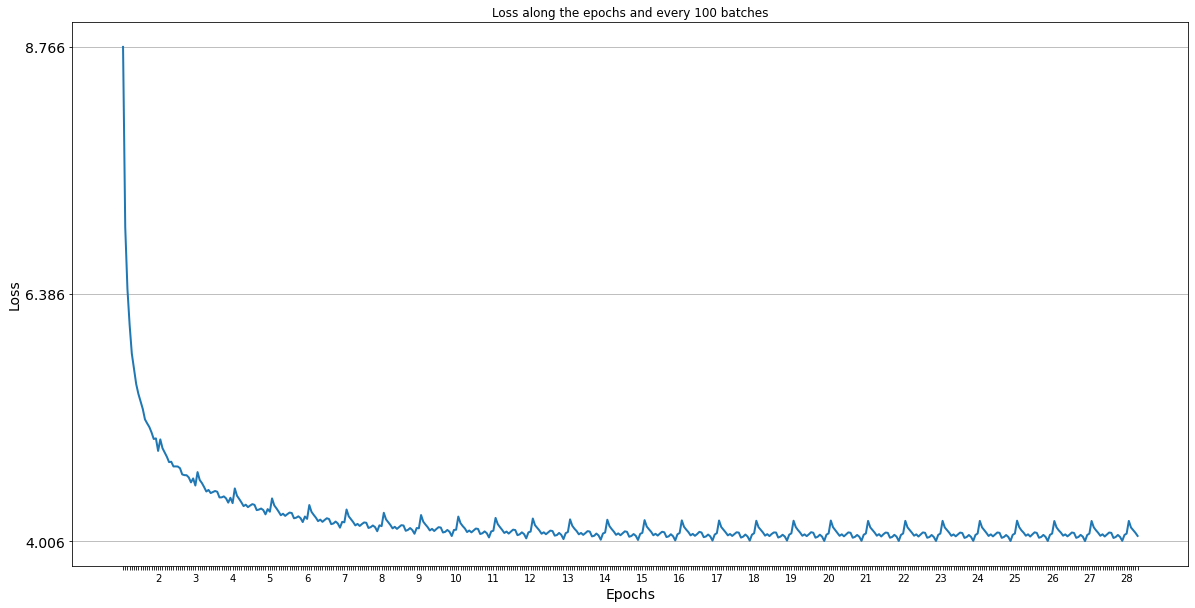

In [ ]:
c_label=0
def display_loss():
  global c_label
  # Load from file
  if os.path.exists(REPORT_PATH):
    plt.figure(figsize=(20, 10))
    data = load_json_file(REPORT_PATH)
    x=[]
    y_data=[]
    
    if data is not None:
      for loss in data['loss']:
        x.append(data['epoch'])
        y_data.append(loss)

    x = range(0, len(data['epoch']))
    c_label = data['epoch'][0]
    x_labels = [1]
  
    x_labels =  [update(label)  for label in data['epoch'][1:]]
    plt.xticks( x, x_labels, fontsize=10)
    plt.yticks([min(y_data), 0.5 * (min(y_data)+ max(y_data)) , max(y_data)], fontsize=14)
    plt.plot(x, y_data, label='Data file size', linewidth=2.0)
    plt.title("Loss along the epochs and every 100 batches")
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(axis='y')
    plt.show()
  else:
    print("Missing report file")
    
def update(label):
  global c_label
  if label > c_label:
    c_label = label
    return label
  return ''

display_loss()


In [ ]:
if DF_EXISTS:
  fig = px.line(df, x='batches', y='loss', color='epoch', title='Loss per number of batches (for each epoch)')
  fig.show()

In [ ]:
if DF_EXISTS:
  fig = px.line(df[26:], x='epoch', y='loss', color='batches', title='Loss per number of epochs (for each number batches)')
  fig.show()

In [ ]:
# Load the best saved model.
if os.path.exists(SAVE_PATH):
  with open(SAVE_PATH, 'rb') as f:
      print(f'Loading {SAVE_PATH.split("/")[-1]}')
      if DEVICE=='cpu':
        model = torch.load(f, map_location=torch.device('cpu'))
      else:
        model = torch.load(f)
      # after load the rnn params are not a continuous chunk of memory
      # this makes them a continuous chunk, and will speed up forward pass
      model.rnn.flatten_parameters()
else:
  print(f"/!\ MISSING {SAVE_PATH.split('/')[-1]}")

Loading H_1_model_cuda_20220204_094757.pt


In [ ]:
# # Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  4.10 | test ppl    60.28
